In [1]:
from __future__ import print_function, division
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM, Bidirectional
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential

2021-12-23 13:53:49.373905: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


In [2]:
import numpy as np
np.random.seed(7)

#import keras
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise
from tensorflow.keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


import pandas as pd
import tensorflow as tf 
physical_devices = tf.config.experimental.list_physical_devices('GPU')
for gpu in physical_devices:
    tf.config.experimental.set_memory_growth(gpu, enable=True)
physical_devices

2021-12-23 13:53:51.926753: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-12-23 13:53:51.981495: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-23 13:53:51.982050: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2080 computeCapability: 7.5
coreClock: 1.8GHz coreCount: 46 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.23GiB/s
2021-12-23 13:53:51.982094: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-12-23 13:53:51.984147: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2021-12-23 13:53:51.986223: I tensorflow/stream_executor/platform/def

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

efault/dso_loader.cc:48] Successfully opened dynamic library libcurand.so.10
2021-12-23 13:53:51.988601: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcusolver.so.10
2021-12-23 13:53:51.989728: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcusparse.so.10
2021-12-23 13:53:51.993821: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7
2021-12-23 13:53:51.994084: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-23 13:53:51.994873: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-23 13:53:51.995314: I tensorflow/core/com

In [3]:
D=pd.read_table("rmPD1_ATNDDY",sep="\t")

D=D[~D.sequence.str.contains("X")]
D=D[~D.sequence.str.contains("O")]
D.shape

(742882, 2)

In [4]:
from numpy.random import seed
seed(1)
Dtrain=D.sample(frac=0.85)
Dtest=D[~D.index.isin(Dtrain.index)]

In [5]:
Dtrain.shape

(631450, 2)

In [6]:
Dtest.shape

(111432, 2)

In [7]:
def df_to_array(df, max_len):
    seq_indices = tokenizer.texts_to_sequences(df['sequence'])
    seq_padding = keras.preprocessing.sequence.pad_sequences(seq_indices, maxlen=max_len)
    
    X_train = seq_padding
    y_train = df['type'].to_numpy(dtype=int)
    
    return X_train, y_train

In [8]:
aa_list = list('ACDEFGHIKLMNPQRSTVWY_')
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True, lower=True)
tokenizer.fit_on_texts(aa_list)
seqs = ['AnNLQRn', 'TNLQR']

# 使用分词器转化为整数序列
seq_indices = tokenizer.texts_to_sequences(seqs)
seq_indices
seq_padding = keras.preprocessing.sequence.pad_sequences(seq_indices, maxlen=7)
DD= dict(zip(tokenizer.word_index.values(), tokenizer.word_index.keys()))
#DD[0]=''
DD

{1: 'a',
 2: 'c',
 3: 'd',
 4: 'e',
 5: 'f',
 6: 'g',
 7: 'h',
 8: 'i',
 9: 'k',
 10: 'l',
 11: 'm',
 12: 'n',
 13: 'p',
 14: 'q',
 15: 'r',
 16: 's',
 17: 't',
 18: 'v',
 19: 'w',
 20: 'y',
 21: '_'}

In [9]:
ml = np.max([len(s) for s in Dtrain['sequence']])
X_dtrain, y_dtrain = df_to_array(Dtrain,ml)
X_dtest, y_dtest = df_to_array(Dtest,ml)
# Wrap data in Dataset objects.
train_data = tf.data.Dataset.from_tensor_slices((X_dtrain, y_dtrain))
#val_data = tf.data.Dataset.from_tensor_slices((X_val, y_val))

# The batch size must now be set on the Dataset objects.
batch_size =128
train_data = train_data.batch(batch_size)
#val_data = val_data.batch(batch_size)

# Disable AutoShard.
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.OFF
train_data = train_data.with_options(options)
#val_data = val_data.with_options(options)
print(X_dtrain.shape)

(631450, 45)


2021-12-23 13:54:34.703295: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-23 13:54:34.710625: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 3593240000 Hz
2021-12-23 13:54:34.712999: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x557bde619520 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-12-23 13:54:34.713074: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-12-23 13:54:34.823757: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2

In [10]:
modelA.summary()

NameError: name 'modelA' is not defined

In [18]:
np.random.seed(7)
strategy1 = tf.distribute.experimental.MultiWorkerMirroredStrategy()
with strategy1.scope():
    modelB = Sequential()
    modelB.add(tf.keras.layers.Embedding(output_dim=21,input_dim=631450,input_length=45))
    modelB.add(tf.keras.layers.LSTM(units=45,return_sequences=True))
    modelB.add(tf.keras.layers.LSTM(units=45))
    #modelD.add(Bidirectional(LSTM(units=45)))
    modelB.add(tf.keras.layers.Dense(1,activation='sigmoid'))
    #modelD.add(TimeDistributed(Dense(1, activation='sigmoid')))
    modelB.compile(
      loss='binary_crossentropy',
      optimizer=tf.keras.optimizers.Adam(lr=0.001),
      metrics=['accuracy'])
    modelB.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/device:GPU:0',)
INFO:tensorflow:Single-worker MultiWorkerMirroredStrategy with local_devices = ('/device:GPU:0',), communication = CollectiveCommunication.AUTO
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 45, 21)            13260450  
_________________________________________________________________
lstm_2 (LSTM)                (None, 45, 45)            12060     
_________________________________________________________________
lstm_3 (LSTM)                (None, 45)                16380     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 46        
Total params: 13,288,936
Trainable params: 13,288,936
Non-trainable params: 0
_________________________________________________________________


In [19]:
#cw = {0: 1, 1:25} class_weight=cw,
history3 = modelB.fit(
    X_dtrain,y_dtrain,
    batch_size=128,    
    epochs=25)

Epoch 1/25
4934/4934 [==============================] - 122s 25ms/step - loss: 0.0919 - accuracy: 0.9707
Epoch 2/25
4934/4934 [==============================] - 122s 25ms/step - loss: 0.0671 - accuracy: 0.9760
Epoch 3/25
4934/4934 [==============================] - 124s 25ms/step - loss: 0.0631 - accuracy: 0.9783
Epoch 4/25
4934/4934 [==============================] - 122s 25ms/step - loss: 0.0603 - accuracy: 0.9795
Epoch 5/25
4934/4934 [==============================] - 124s 25ms/step - loss: 0.0578 - accuracy: 0.9806
Epoch 6/25
4934/4934 [==============================] - 122s 25ms/step - loss: 0.0554 - accuracy: 0.9817
Epoch 7/25
4934/4934 [==============================] - 121s 25ms/step - loss: 0.0531 - accuracy: 0.9827
Epoch 8/25
4934/4934 [==============================] - 120s 24ms/step - loss: 0.0512 - accuracy: 0.9835
Epoch 9/25
4934/4934 [==============================] - 122s 25ms/step - loss: 0.0499 - accuracy: 0.9841
Epoch 10/25
4934/4934 [==============================] 

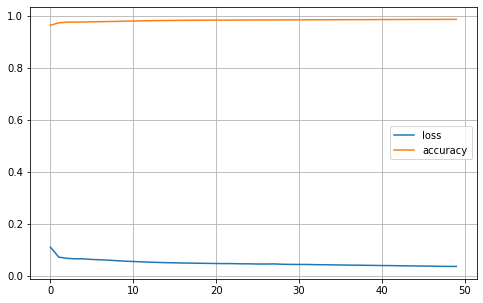

In [13]:
pd.DataFrame(history3.history).plot(figsize=(8,5))
plt.grid(True)
plt.show()

In [14]:
predict=modelA.predict(X_dtest)
y_true=pd.Series(y_dtest,name="Actually")
y_predict=pd.Series(np.around(predict).reshape(111432),name="Predict")

In [15]:
pd.crosstab(y_true, y_predict)

Predict,0.0,1.0
Actually,,
0,106309,298
1,1466,3359


In [16]:
Dtest.reset_index(drop=True,inplace=True)

In [17]:
Dtest["predict"]= y_predict

/home/cxj/anaconda3/envs/tensorflow_gpu2.3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [18]:
Dtest.to_csv("40X_LSTM_predict_TrueCDR_Epitope_token_rmPD1_ATNDDY_Test0.15_new.txt",sep="\t",index=False)

In [19]:
modelA.save("40X_TrueLike_model_LSTM1_rmPD1_ATNDDY_new.h5")

In [20]:
def df_to_arrayNew(df, max_len):
    seq_indices = tokenizer.texts_to_sequences(df['sequence'])
    seq_padding = keras.preprocessing.sequence.pad_sequences(seq_indices, maxlen=max_len)
    
    X_train = seq_padding
    #y_train = df['type'].to_numpy(dtype=int)
    
    return X_train

In [19]:
#C=pd.read_table("/hdd/public/cxj/zym/CD22_DL/Epuzumab.Epitope1.txt",sep="\t",header=None)
C=pd.read_table("Generate_OAS_CDR_less.Eputazu",sep="\t",header=None)
C.columns=["sequence"]
#C["sequence"]="ARRDITTFY_"+C["sequence"]

FileNotFoundError: [Errno 2] No such file or directory: 'Generate_OAS_CDR_less.Eputazu'

In [22]:
ml = np.max([len(s) for s in C['sequence']])
X = df_to_arrayNew(C,45)

In [23]:
C.shape

(533016, 1)

In [25]:
C["predict"]=modelA.predict(X)

In [26]:
C[C.predict>0.5]

,sequence,predict
25,ASRGGYTYYMDV_HILPPELEGRWSHGKIDTVQ,0.561264
76,ARARASAGYSTGRLYYTYYMDV_HILPPELEGRWSHGKIDTVQ,0.565017
94,RRRDRGGSYSYGRSDAFDY_HILPPELEGRWSHGKIDTVQ,0.525148
100,RRLLGSYYYWTDH_HILPPELEGRWSHGKIDTVQ,0.625184
101,RRLLGSYYYWTDH_ILPPELEGRWSHGKIDTVQL,0.748863
...,...,...
532990,ARVAYYYSSDAFDY_HILPPELEGRWSHGKIDTVQ,0.892315
532999,RSRYGYGSSSYAMDY_HILPPELEGRWSHGKIDTVQ,0.522055
533008,EYRGSSGYYYYMDV_HILPPELEGRWSHGKIDTVQ,0.855886
533011,ARGRYYYGSYYDAFDI_HILPPELEGRWSHGKIDTVQ,0.680485


In [27]:
C=C.sort_values(by="predict",ascending=False)

In [28]:
C[C.predict>0.95]

,sequence,predict
418982,ARGAYSRDPDGYGGFGV_ILPPELEGRWSHGKIDTVQL,0.999302
418981,ARGAYSRDPDGYGGFGV_HILPPELEGRWSHGKIDTVQ,0.996877
437854,ARAGSDYGSGYYYYYMGV_HILPPELEGRWSHGKIDTVQ,0.996419
80171,HYGSGGYYGYYYAMDY_ILPPELEGRWSHGKIDTVQL,0.996013
436807,RARGGYGSDWYDGYGGMDV_HILPPELEGRWSHGKIDTVQ,0.995686
...,...,...
364036,AKSRSWYGGGAFDI_HILPPELEGRWSHGKIDTVQ,0.950045
363575,AGDSWGYYYYGAMDV_ILPPELEGRWSHGKIDTVQL,0.950034
519004,ARGTYYGGDYGGFAY_HILPPELEGRWSHGKIDTVQ,0.950031
90780,ARGSYYGSGYLFAY_PHILPPELEGRWSHGKIDTV,0.950028


In [29]:
#C.to_csv("LSTM_Epuzumab.Epitope1.predict.txt",sep="\t",index=False)
C.to_csv("40XLSTM_GenerateOAS_epitopeTop3_predict_ALL.txt",sep="\t",index=False)

In [21]:
IN=pd.read_table("Epuzumab.Epitope1.txt",header=None)
IN.columns=['sequence']
IN['sequence']="ARRDITTFY_"+IN['sequence']
IN1=df_to_arrayNew(IN,45)

In [23]:
IN['predict']=modelB.predict(IN1)

In [24]:
IN=IN.sort_values(by="predict",ascending=False)
IN

,sequence,predict
5,ARRDITTFY_PELEGRWSHGKIDTVQLNKE,0.116307
4,ARRDITTFY_PPELEGRWSHGKIDTVQLNK,0.086823
14,ARRDITTFY_GKIDTVQLNKEKCEVSSNPE,0.070042
15,ARRDITTFY_KIDTVQLNKEKCEVSSNPEY,0.064783
13,ARRDITTFY_HGKIDTVQLNKEKCEVSSNP,0.052844
16,ARRDITTFY_IDTVQLNKEKCEVSSNPEYT,0.047282
11,ARRDITTFY_WSHGKIDTVQLNKEKCEVSS,0.043191
10,ARRDITTFY_RWSHGKIDTVQLNKEKCEVS,0.041448
12,ARRDITTFY_SHGKIDTVQLNKEKCEVSSN,0.037482
9,ARRDITTFY_GRWSHGKIDTVQLNKEKCEV,0.027970


In [6]:
C1=pd.read_table("Generate_OAS_Epitope_12.12.uniq.less.40x.NotUsed",sep="\t",header=None)
C1.columns=["sequence"]
C2=pd.read_table("Generate_OAS_Epitope_12.12.uniq.less.40x.NotUsed",sep="\t",header=None)
C2.columns=["sequence"]
C3=pd.read_table("Generate_OAS_Epitope_12.12.uniq.less.40x.NotUsed",sep="\t",header=None)
C3.columns=["sequence"]

In [7]:
C1["sequence"]=C1["sequence"]+"_IDTVQLNKEKCEVSSNPEYT"
C2["sequence"]=C2["sequence"]+"_SHGKIDTVQLNKEKCEVSSN"
C3["sequence"]=C3["sequence"]+"_ILPPELEGRWSHGKIDTVQL"

In [10]:
#ml = np.max([len(s) for s in C1['sequence']])
#X1 = df_to_arrayNew(C1,45)
#print(X1.shape)
#X2 = df_to_arrayNew(C2,45)
#print(X2.shape)
#X3 = df_to_arrayNew(C3,45)
#print(X3.shape)
for i in range(0,C1.shape[0],5000):
    print(i)
    X1 = df_to_arrayNew(C1.loc[i:i+5000],45)
    C1.loc[i:i+5000,"predict_LSTM"]=model4.predict(X1)

0
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


2021-12-19 10:10:05.991363: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2021-12-19 10:10:06.487029: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7


5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000
100000
105000
110000
115000
120000
125000
130000
135000
140000
145000
150000
155000
160000
165000
170000
175000
180000
185000
190000
195000
200000
205000
210000
215000
220000
225000
230000
235000
240000
245000
250000
255000
260000
265000
270000
275000
280000
285000
290000
295000
300000
305000
310000
315000
320000
325000
330000
335000
340000
345000
350000
355000
360000
365000
370000
375000
380000
385000
390000
395000
400000
405000
410000
415000
420000
425000
430000
435000
440000
445000
450000
455000
460000
465000
470000
475000
480000
485000
490000
495000
500000
505000
510000
515000
520000
525000
530000
535000
540000
545000
550000
555000
560000
565000
570000
575000
580000
585000
590000
595000
600000
605000
610000
615000
620000
625000
630000
635000
640000
645000
650000
655000
660000
665000
670000
675000
680000
685000
690000
695000
700000
705000
710000
715000
720000
725000
73000

5265000
5270000
5275000
5280000
5285000
5290000
5295000
5300000
5305000
5310000
5315000
5320000
5325000
5330000
5335000
5340000
5345000
5350000
5355000
5360000
5365000
5370000
5375000
5380000
5385000
5390000
5395000
5400000
5405000
5410000
5415000
5420000
5425000
5430000
5435000
5440000
5445000
5450000
5455000
5460000
5465000
5470000
5475000
5480000
5485000
5490000
5495000
5500000
5505000
5510000
5515000
5520000
5525000
5530000
5535000
5540000
5545000
5550000
5555000
5560000
5565000
5570000
5575000
5580000
5585000
5590000
5595000
5600000
5605000
5610000
5615000
5620000
5625000
5630000
5635000
5640000
5645000
5650000
5655000
5660000
5665000
5670000
5675000
5680000
5685000
5690000
5695000
5700000
5705000
5710000
5715000
5720000
5725000
5730000
5735000
5740000
5745000
5750000
5755000
5760000
5765000
5770000
5775000
5780000
5785000
5790000
5795000
5800000
5805000
5810000
5815000
5820000
5825000
5830000
5835000
5840000
5845000
5850000
5855000
5860000
5865000
5870000
5875000
5880000
5885000


10345000
10350000
10355000
10360000
10365000
10370000
10375000
10380000
10385000
10390000
10395000
10400000
10405000
10410000
10415000
10420000
10425000
10430000
10435000
10440000
10445000
10450000
10455000
10460000
10465000
10470000
10475000
10480000
10485000
10490000
10495000
10500000
10505000
10510000
10515000
10520000
10525000
10530000
10535000
10540000
10545000
10550000
10555000
10560000
10565000
10570000
10575000
10580000
10585000
10590000
10595000
10600000
10605000
10610000
10615000
10620000
10625000
10630000
10635000
10640000
10645000
10650000
10655000
10660000
10665000
10670000
10675000
10680000
10685000
10690000
10695000
10700000
10705000
10710000
10715000
10720000
10725000
10730000
10735000
10740000
10745000
10750000
10755000
10760000
10765000
10770000
10775000
10780000
10785000
10790000
10795000
10800000
10805000
10810000
10815000
10820000
10825000
10830000
10835000
10840000
10845000
10850000
10855000
10860000
10865000
10870000
10875000
10880000
10885000
10890000
10895000
1

14900000
14905000
14910000
14915000
14920000
14925000
14930000
14935000
14940000
14945000
14950000
14955000
14960000
14965000
14970000
14975000
14980000
14985000
14990000
14995000
15000000
15005000
15010000
15015000
15020000
15025000
15030000
15035000
15040000
15045000
15050000
15055000
15060000
15065000
15070000
15075000
15080000
15085000
15090000
15095000
15100000
15105000
15110000
15115000
15120000
15125000
15130000
15135000
15140000
15145000
15150000
15155000
15160000
15165000
15170000
15175000
15180000
15185000
15190000
15195000
15200000
15205000
15210000
15215000
15220000
15225000
15230000
15235000
15240000
15245000
15250000
15255000
15260000
15265000
15270000
15275000
15280000
15285000
15290000
15295000
15300000
15305000
15310000
15315000
15320000
15325000
15330000
15335000
15340000
15345000
15350000
15355000
15360000
15365000
15370000
15375000
15380000
15385000
15390000
15395000
15400000
15405000
15410000
15415000
15420000
15425000
15430000
15435000
15440000
15445000
15450000
1

19455000
19460000
19465000
19470000
19475000
19480000
19485000
19490000
19495000
19500000
19505000
19510000
19515000
19520000
19525000
19530000
19535000
19540000
19545000
19550000
19555000
19560000
19565000
19570000
19575000
19580000
19585000
19590000
19595000
19600000
19605000
19610000
19615000
19620000
19625000
19630000
19635000
19640000
19645000
19650000
19655000
19660000
19665000
19670000
19675000
19680000
19685000
19690000
19695000
19700000
19705000
19710000
19715000
19720000
19725000
19730000
19735000
19740000
19745000
19750000
19755000
19760000
19765000
19770000
19775000
19780000
19785000
19790000
19795000
19800000
19805000
19810000
19815000
19820000
19825000
19830000
19835000
19840000
19845000
19850000
19855000
19860000
19865000
19870000
19875000
19880000
19885000
19890000
19895000
19900000
19905000
19910000
19915000
19920000
19925000
19930000
19935000
19940000
19945000
19950000
19955000
19960000
19965000
19970000
19975000
19980000
19985000
19990000
19995000
20000000
20005000
2

24010000
24015000
24020000
24025000
24030000
24035000
24040000
24045000
24050000
24055000
24060000
24065000
24070000
24075000
24080000
24085000
24090000
24095000
24100000
24105000
24110000
24115000
24120000
24125000
24130000
24135000
24140000
24145000
24150000
24155000
24160000
24165000
24170000
24175000
24180000
24185000
24190000
24195000
24200000
24205000
24210000
24215000
24220000
24225000
24230000
24235000
24240000
24245000
24250000
24255000
24260000
24265000
24270000
24275000
24280000
24285000
24290000
24295000
24300000
24305000
24310000
24315000
24320000
24325000
24330000
24335000
24340000
24345000
24350000
24355000
24360000
24365000
24370000
24375000
24380000
24385000
24390000
24395000
24400000
24405000
24410000
24415000
24420000
24425000
24430000
24435000
24440000
24445000
24450000
24455000
24460000
24465000
24470000
24475000
24480000
24485000
24490000
24495000
24500000
24505000
24510000
24515000
24520000
24525000
24530000
24535000
24540000
24545000
24550000
24555000
24560000
2

28565000
28570000
28575000
28580000
28585000
28590000
28595000
28600000
28605000
28610000
28615000
28620000
28625000
28630000
28635000
28640000
28645000
28650000
28655000
28660000
28665000
28670000
28675000
28680000
28685000
28690000
28695000
28700000
28705000
28710000
28715000
28720000
28725000
28730000
28735000
28740000
28745000
28750000
28755000
28760000
28765000
28770000
28775000
28780000
28785000
28790000
28795000
28800000
28805000
28810000
28815000
28820000
28825000
28830000
28835000
28840000
28845000
28850000
28855000
28860000
28865000
28870000
28875000
28880000
28885000
28890000
28895000
28900000
28905000
28910000
28915000
28920000
28925000
28930000
28935000
28940000
28945000
28950000
28955000
28960000
28965000
28970000
28975000
28980000
28985000
28990000
28995000
29000000
29005000
29010000
29015000
29020000
29025000
29030000
29035000
29040000
29045000
29050000
29055000
29060000
29065000
29070000
29075000
29080000
29085000
29090000
29095000
29100000
29105000
29110000
29115000
2

33120000
33125000
33130000
33135000
33140000
33145000
33150000
33155000
33160000
33165000
33170000
33175000
33180000
33185000
33190000
33195000
33200000
33205000
33210000
33215000
33220000
33225000
33230000
33235000
33240000
33245000
33250000
33255000
33260000
33265000
33270000
33275000
33280000
33285000
33290000
33295000
33300000
33305000
33310000
33315000
33320000
33325000
33330000
33335000
33340000
33345000
33350000
33355000
33360000
33365000
33370000
33375000
33380000
33385000
33390000
33395000
33400000
33405000
33410000
33415000
33420000
33425000
33430000
33435000
33440000
33445000
33450000
33455000
33460000
33465000
33470000
33475000
33480000
33485000
33490000
33495000
33500000
33505000
33510000
33515000
33520000
33525000
33530000
33535000
33540000
33545000
33550000
33555000
33560000
33565000
33570000
33575000
33580000
33585000
33590000
33595000
33600000
33605000
33610000
33615000
33620000
33625000
33630000
33635000
33640000
33645000
33650000
33655000
33660000
33665000
33670000
3

37675000
37680000
37685000
37690000
37695000
37700000
37705000
37710000
37715000
37720000
37725000
37730000
37735000
37740000
37745000
37750000
37755000
37760000
37765000
37770000
37775000
37780000
37785000
37790000
37795000
37800000
37805000
37810000
37815000
37820000
37825000
37830000
37835000
37840000
37845000
37850000
37855000
37860000
37865000
37870000
37875000
37880000
37885000
37890000
37895000
37900000
37905000
37910000
37915000
37920000
37925000
37930000
37935000
37940000
37945000
37950000
37955000
37960000
37965000
37970000
37975000
37980000
37985000
37990000
37995000
38000000
38005000
38010000
38015000
38020000
38025000
38030000
38035000
38040000
38045000
38050000
38055000
38060000
38065000
38070000
38075000
38080000
38085000
38090000
38095000
38100000
38105000
38110000
38115000
38120000
38125000
38130000
38135000
38140000
38145000
38150000
38155000
38160000
38165000
38170000
38175000
38180000
38185000
38190000
38195000
38200000
38205000
38210000
38215000
38220000
38225000
3

In [11]:
for j in range(0,C2.shape[0],10000):    
    X2 = df_to_arrayNew(C2.loc[j:j+10000],45)
    C2.loc[j:j+10000,"predict_LSTM"]=model4.predict(X2)

In [12]:
for k in range(0,C3.shape[0],10000):    
    X3 = df_to_arrayNew(C3.loc[k:k+10000],45)
    C3.loc[k:k+10000,"predict_LSTM"]=model4.predict(X3)

In [13]:
C=pd.concat([C1,C2,C3],axis=0)

In [14]:
C[C.predict_LSTM>0.5]


,sequence,predict_LSTM
322960,AADGDDGGAMDY_IDTVQLNKEKCEVSSNPEYT,0.785279
323027,AADGDDGGYFGY_IDTVQLNKEKCEVSSNPEYT,0.535325
726744,AAGGGGSSGYYDY_IDTVQLNKEKCEVSSNPEYT,0.530539
726755,AAGGGGSSGYYYY_IDTVQLNKEKCEVSSNPEYT,0.543407
726811,AAGGGGSSSGMDY_IDTVQLNKEKCEVSSNPEYT,0.538081
...,...,...
42013644,VTDRYYGGMDV_ILPPELEGRWSHGKIDTVQL,0.806276
42034454,VTIVEYYPFDY_ILPPELEGRWSHGKIDTVQL,0.703142
42034468,VTIVGDGAMDY_ILPPELEGRWSHGKIDTVQL,0.552270
42054760,VVPYDYSSYWYY_ILPPELEGRWSHGKIDTVQL,0.522203


In [15]:
C[C.predict_LSTM>0.95]

,sequence,predict_LSTM
824936,AAGHYGRIGYGMDY_IDTVQLNKEKCEVSSNPEYT,0.958184
1524045,AARDRRDSYYYYYFDY_IDTVQLNKEKCEVSSNPEYT,0.999913
2375362,AARTGRGYSGYYYAMDY_IDTVQLNKEKCEVSSNPEYT,0.955860
5013551,AGGLRYGSAMDY_IDTVQLNKEKCEVSSNPEYT,0.953128
5018554,AGGLYDYGAMDY_IDTVQLNKEKCEVSSNPEYT,0.999659
...,...,...
41087229,TKSAGGAFDY_ILPPELEGRWSHGKIDTVQL,0.986526
41611054,TVGYGGPMDV_ILPPELEGRWSHGKIDTVQL,0.977680
41665281,TYRYYDGGSYWFAY_ILPPELEGRWSHGKIDTVQL,0.969409
41846492,VRDGDGGPFDY_ILPPELEGRWSHGKIDTVQL,0.968443


In [16]:
#C=C.sort_values(by="predict_Transformer",ascending=False)

In [17]:
C.to_csv("400X_OAS_NotUsed_predict_LSTM.txt",sep="\t",index=False)